# Absorption Ratio

Diego Alvarez (diego.alvarez@colorado.edu)

In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from DataSource import DataCollect
from AbsorptionRatio import AbsorptionRatio

## Get Data

In [2]:
def prep_data() -> pd.DataFrame:
    
    df_prep = (DataCollect().get_spx_names().query(
        "variable_0 == 'Adj Close'").
        drop(columns = ["variable_0"]).
        pivot(index = "Date", columns = "variable_1", values = "value").
        pct_change().
        fillna(0))
    
    return df_prep

df_prep = prep_data()

found data


In [3]:
def prep_spx() -> pd.DataFrame:
    
    df_spx = (DataCollect().get_spx_rtn().rename(
        columns = {"Adj Close": "SPX"})
        [["SPX"]].
        sort_index())
    
    return df_spx

df_spx = prep_spx()

found data


In this case we are going to use $n$ components that is 20% of our features (100). The absorption ratio is the measure of the cumulative $n$ PC's variance divided by the cumulative variance of the total dataset. In this case we'll use a lookback window of ssize 500.
\begin{equation}
AR = \frac{\sum_{i = 1}^n \sigma_{E,i}^2}{\sum_{j = 1}^N \sigma_{A,j}^2}
\end{equation}

In [4]:
def get_absorption(df_prep: pd.DataFrame) -> pd.DataFrame: 
    
    path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "data", "absorption_ratio.parquet")

    try:

        df_absorption = pd.read_parquet(path = path, engine = "pyarrow")

    except: 

        n_components = int(len(df_prep.columns) * 0.2)
        df_absorption = AbsorptionRatio().get_absorption_ratio(df_prep, n_components = n_components)
        df_absorption.to_parquet(path = path, engine = "pyarrow")
        
    return df_absorption

df_absorption = get_absorption(df_prep)

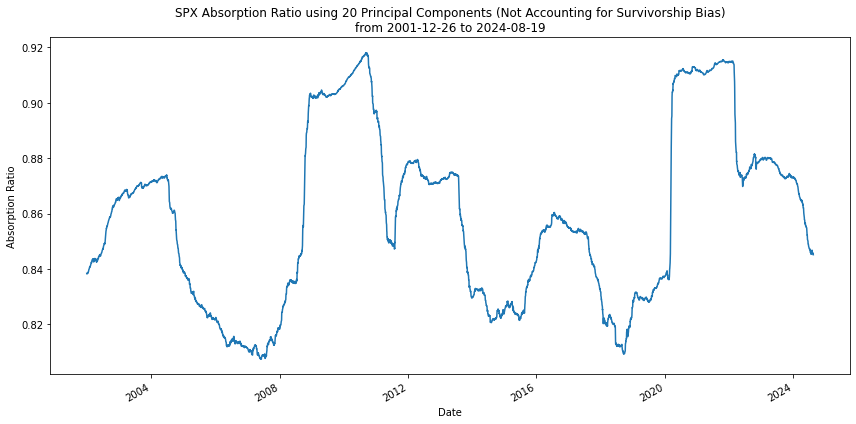

In [5]:
def plot_absorption_ratio(df_absorption: pd.DataFrame) -> plt.Figure: 

    df_absorption.set_index("Date").plot(
        figsize = (12,6),
        ylabel = "Absorption Ratio",
        legend = False,
        title = "SPX Absorption Ratio using 20 Principal Components (Not Accounting for Survivorship Bias)\nfrom {} to {}".format(
            df_absorption.Date.min().date(),
            df_absorption.Date.max().date()))
    
    plt.tight_layout()
    
plot_absorption_ratio(df_absorption)

From a visual standpoint of the raw time series it is evident that our measurement picks up on risk on and risk off events which occur during the 2008 recession and COVID. Since the absorption ratio is a slightly modified measurement tied to implied correlation it has similar properties. 

The authors turn this time series into a tradable signal by using the following modification. Which is simply a volatility scaled trend follower. 

\begin{equation}
\Delta AR = \frac{AR_{15d} - AR_{1Yr}}{\sigma_{1Yr}}
\end{equation}

In [6]:
def signalize_absorption_ratio(df_absorption: pd.DataFrame, short_window: int = 15, long_window: int = 250) -> pd.DataFrame: 

    df_out = (df_absorption.assign(
        short_window = lambda x: x.AR.ewm(span = short_window, adjust = False).mean(),
        long_window = lambda x: x.AR.ewm(span = long_window, adjust = False).mean(),
        vol = lambda x: x.AR.ewm(span = long_window, adjust = False).std(),
        signal = lambda x: (x.short_window - x.long_window) / x.vol,
        lag_signal = lambda x: x.signal.shift()))
    
    return df_out
    
df_signal = signalize_absorption_ratio(df_absorption)